In [21]:
import sys
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.distance import euclidean

from transformers import pipeline
from sklearn.decomposition import PCA

sys.path.append(os.path.abspath(".."))

from data.dataset_factory import get_dataset_generator
from preprocessing.embedding_chunks import get_ready_to_embed_chunks
from preprocessing.mean_pool_chunks import mean_pool_chunks
from preprocessing.block_splitter import deverbose_ast

In [22]:
import os
clonetype = "type-2"

print(os.getcwd())
gen = get_dataset_generator(
    dataset_name="codeclonedataset",
    mode="pairs",
    dataset_root="data/code-clone-dataset/dataset",
    clone_type=clonetype
)

sample = next(gen)
sample

/Users/jonas/Documents/NTNU/Bachelor/code-model-embeddings/notebooks


('public class Calculator {\n    public int add(int a, int b) { return a + b; }\n    public int subtract(int a, int b) { return a - b; }\n    public int multiply(int a, int b) { return a * b; }\n    public int divide(int a, int b) { return b != 0 ? a / b : 0; }\n    public int modulo(int a, int b) { return b != 0 ? a % b : 0; }\n\n    public static void main(String[] args) {\n        Calculator calc = new Calculator();\n        System.out.println("2 + 3 = " + calc.add(2, 3));\n    }\n}\n',
 ['public class Calculator {\n    // Add two numbers\n    public int sum(int x, int y) { return x + y; }\n\n    // Subtract second number from first\n    public int difference(int x, int y) { return x - y; }\n\n    // Multiply two numbers\n    public int product(int x, int y) { return x * y; }\n\n    // Divide first number by second; returns 0 if divisor is zero\n    public int quotient(int x, int y) { return y != 0 ? x / y : 0; }\n\n    // Compute remainder of division\n    public int remainder(int 

In [23]:
unixcoder = "microsoft/unixcoder-base"
unixoder_pipe = pipeline("feature-extraction", model=unixcoder)

codebert = "microsoft/codebert-base"
codebert_pipe = pipeline("feature-extraction", model=codebert)

graphcodebert = "microsoft/graphcodebert-base"
graphcodebert_pipe = pipeline("feature-extraction", model=graphcodebert)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2117.51it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: microsoft/unixcoder-base
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 197/197 [00:00<00:00, 2287.83it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: microsoft/graphcodebert-base
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bi

In [24]:
models = {
    "UniXcoder": unixoder_pipe,
    "CodeBERT": codebert_pipe,
    "GraphCodeBERT": graphcodebert_pipe
}

In [25]:
def extract_code_chunks(chunks):
    """
    Input: [(method, code_chunk, ast_chunk), ...]
    Output: [code_chunk, ...]
    """
    out = []
    for method, code, ast in chunks:
        code = code.strip()
        if code:
            out.append(code)
    return out

In [26]:
def embed_chunks(chunks, pipe):
    embeddings = []

    for chunk in chunks:
        if not isinstance(chunk, str):
            raise TypeError(f"Expected string, got {type(chunk)}")

        out = pipe(
            chunk,
            truncation=True,
            padding=False
        )

        out = np.array(out)

        # [1, tokens, hidden]
        emb = out[0].mean(axis=0)
        embeddings.append(emb)

    return np.stack(embeddings)


In [27]:
def smooth_embeddings(embs, window=100, poly=3):
    # Apply smoothing across embedding dimension
    return scipy.signal.savgol_filter(embs, window, poly, axis=1, mode='mirror')


In [28]:
def cumulative_l2(anchor_embs, other_embs):
    min_len = min(len(anchor_embs), len(other_embs))
    dist = 0.0
    for i in range(min_len):
        dist += euclidean(anchor_embs[i], other_embs[i])
    return dist



Embedding model: UniXcoder
0, CUM_L2(anchor, clone)=2.3752, CUM_L2(anchor, non-clone)=6.8646
// ANCHOR:
// public void addTask(String task) { tasks.add(task); }
// CLONE 1:
// public void addItem(String item) { taskItems.add(item); } // add task
// NON-CLONE 1:
// if(grid[r][c] == '-') {


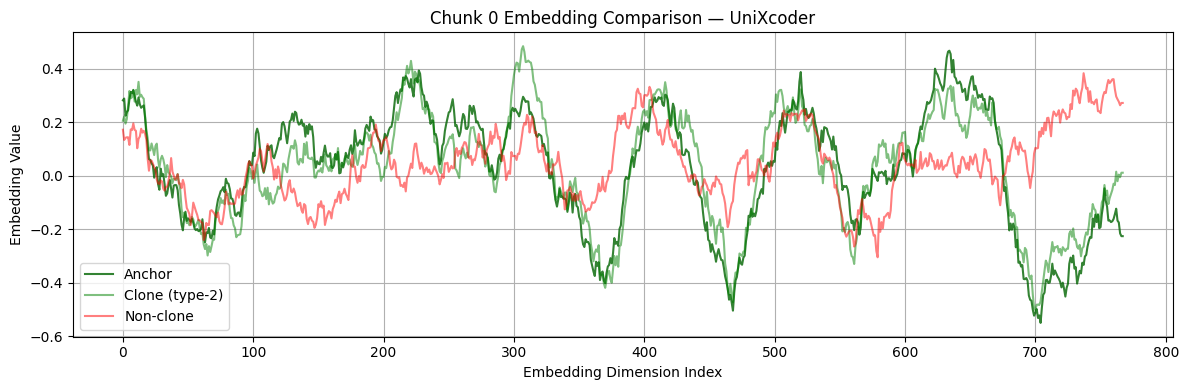

1, CUM_L2(anchor, clone)=2.6585, CUM_L2(anchor, non-clone)=6.3207
// ANCHOR:
// public void removeTask(int index) { tasks.remove(index); }
// CLONE 1:
// public void deleteItem(int idx) { taskItems.remove(idx); } // remove task
// NON-CLONE 1:
// return false;


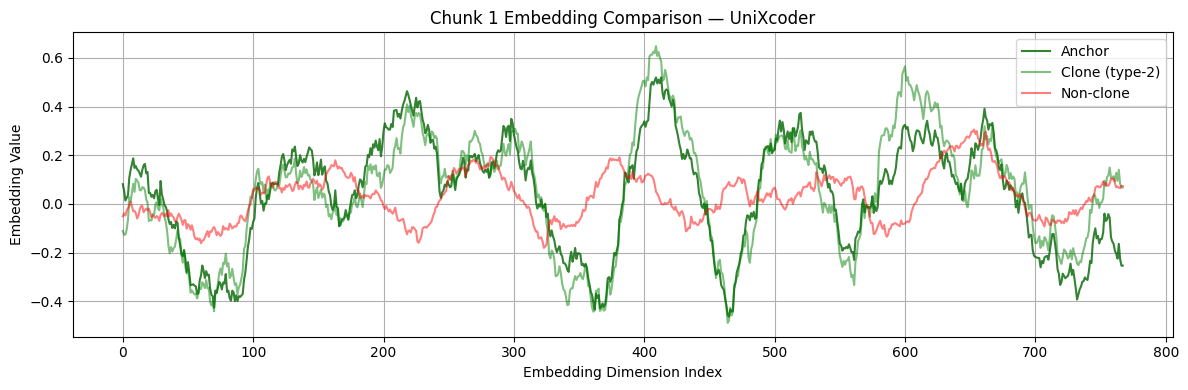

2, CUM_L2(anchor, clone)=3.4538, CUM_L2(anchor, non-clone)=6.0444
// ANCHOR:
// public void updateTask(int index, String task) { tasks.set(index, task); }
// CLONE 1:
// public void modifyItem(int idx, String item) { taskItems.set(idx, item); } // update task
// NON-CLONE 1:
// for(char[] row : grid) {


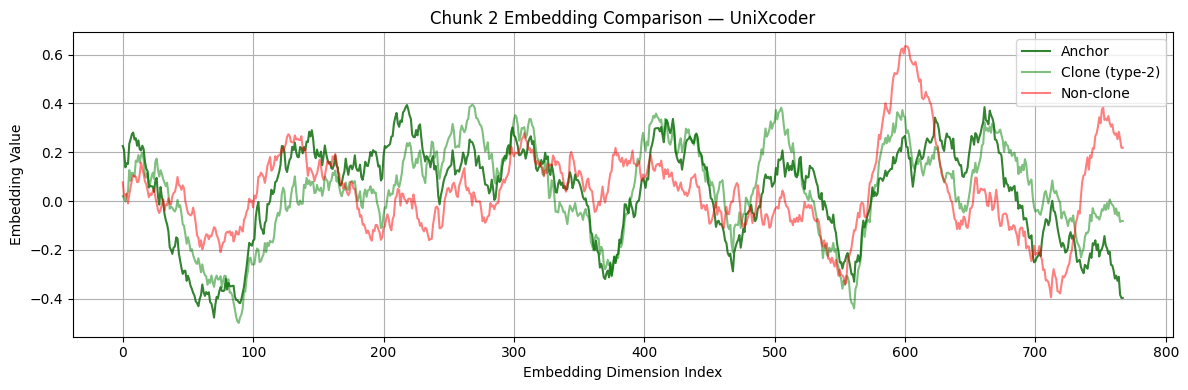

3, CUM_L2(anchor, clone)=3.4776, CUM_L2(anchor, non-clone)=6.9668
// ANCHOR:
// public void viewTasks() { tasks.forEach(System.out::println); }
// CLONE 1:
// public void showItems() { taskItems.forEach(System.out::println); } // display tasks
// NON-CLONE 1:
// for(int i=0;i<3;i++)


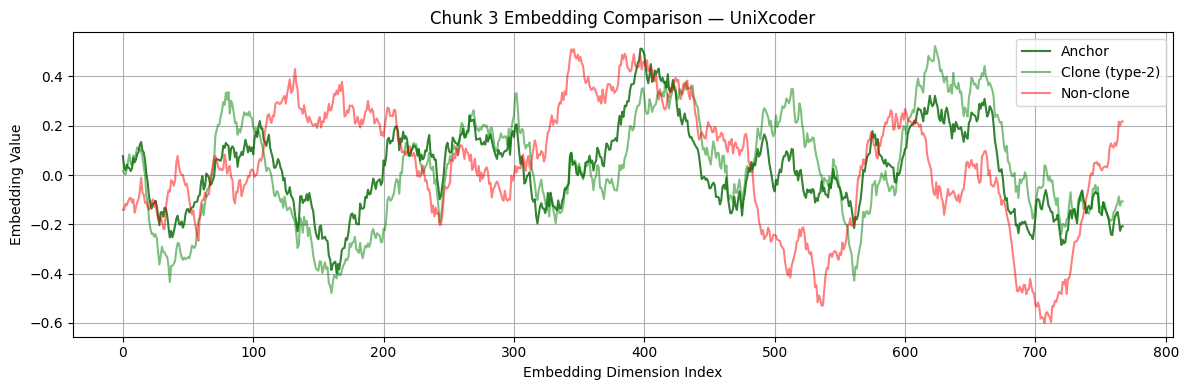

4, CUM_L2(anchor, clone)=3.6394, CUM_L2(anchor, non-clone)=5.6670
// ANCHOR:
// public void markDone(int index) { tasks.set(index, tasks.get(index) + " ✅"); }
// CLONE 1:
// public void completeItem(int idx) { taskItems.set(idx, taskItems.get(idx) + " ✅"); } // mark done
// NON-CLONE 1:
// return false;


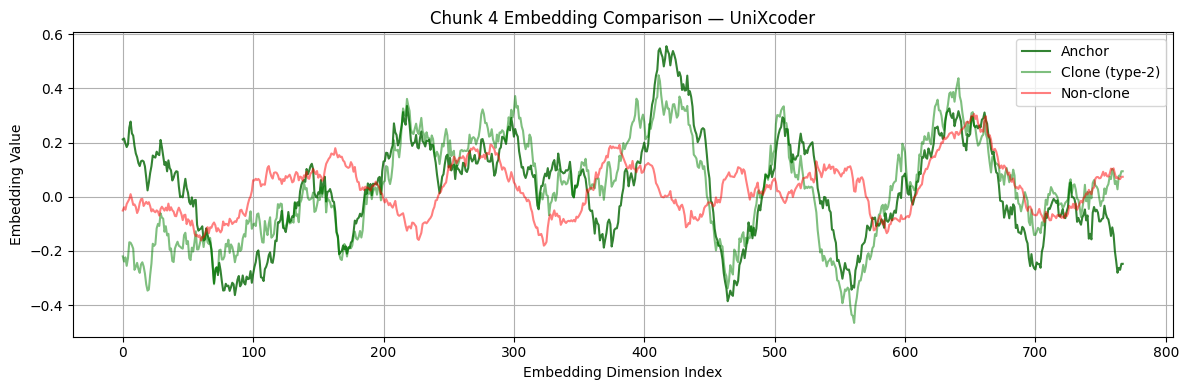

5, CUM_L2(anchor, clone)=5.3712, CUM_L2(anchor, non-clone)=6.5365
// ANCHOR:
// ToDoList list = new ToDoList();
//         list.addTask("Write code");
//         list.viewTasks();
// CLONE 1:
// TaskManager tm = new TaskManager();
//         tm.addItem("Write code");
//         tm.showItems();
// NON-CLONE 1:
// for(int r=0;r<3;r++)


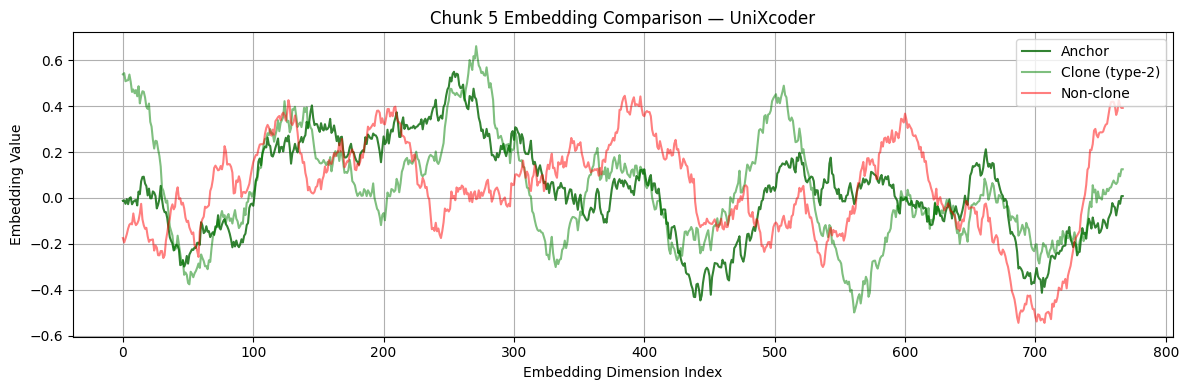


Embedding model: CodeBERT
0, CUM_L2(anchor, clone)=1.0210, CUM_L2(anchor, non-clone)=1.6895
// ANCHOR:
// public void addTask(String task) { tasks.add(task); }
// CLONE 1:
// public void addItem(String item) { taskItems.add(item); } // add task
// NON-CLONE 1:
// if(grid[r][c] == '-') {


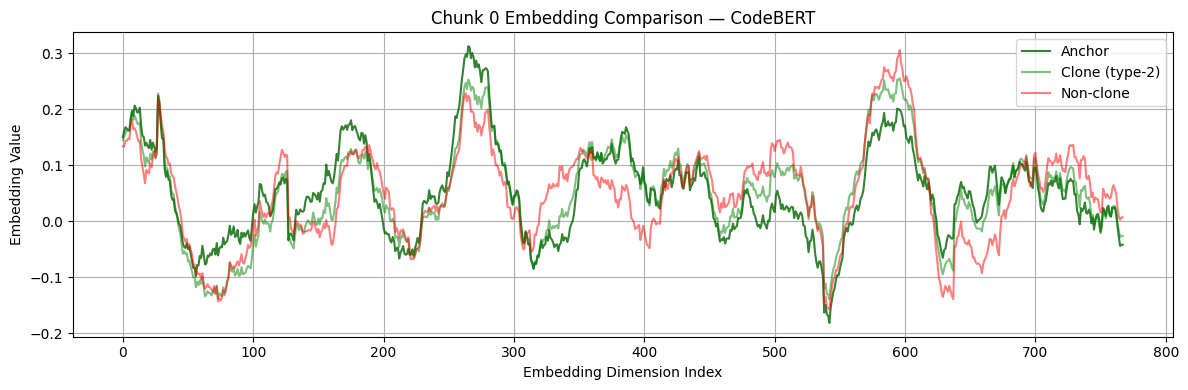

1, CUM_L2(anchor, clone)=0.9937, CUM_L2(anchor, non-clone)=1.5081
// ANCHOR:
// public void removeTask(int index) { tasks.remove(index); }
// CLONE 1:
// public void deleteItem(int idx) { taskItems.remove(idx); } // remove task
// NON-CLONE 1:
// return false;


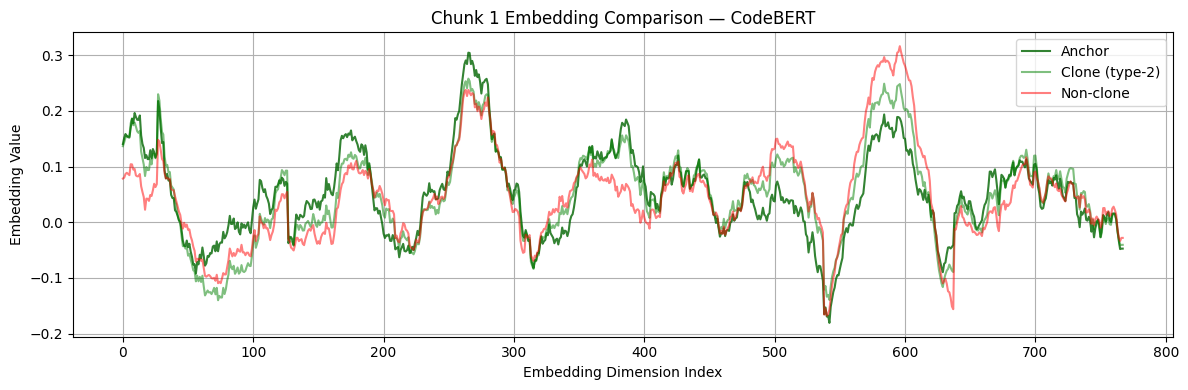

2, CUM_L2(anchor, clone)=0.8147, CUM_L2(anchor, non-clone)=1.3350
// ANCHOR:
// public void updateTask(int index, String task) { tasks.set(index, task); }
// CLONE 1:
// public void modifyItem(int idx, String item) { taskItems.set(idx, item); } // update task
// NON-CLONE 1:
// for(char[] row : grid) {


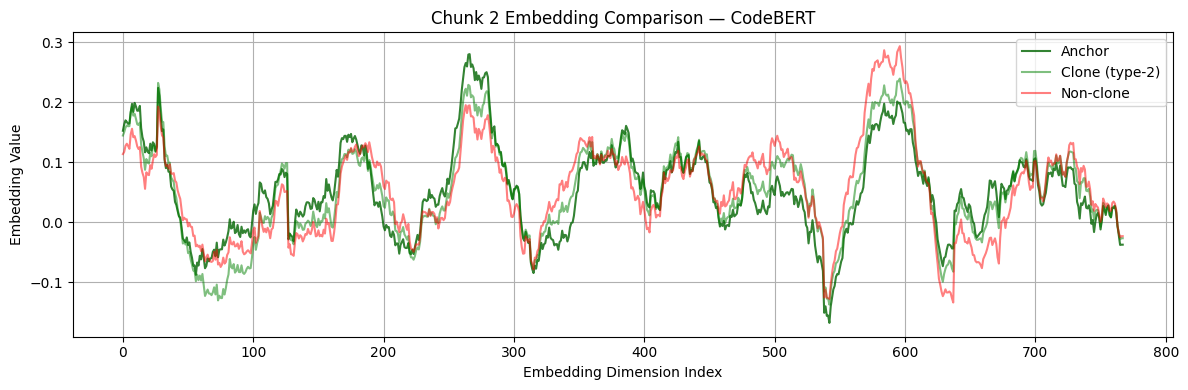

3, CUM_L2(anchor, clone)=0.7603, CUM_L2(anchor, non-clone)=0.9020
// ANCHOR:
// public void viewTasks() { tasks.forEach(System.out::println); }
// CLONE 1:
// public void showItems() { taskItems.forEach(System.out::println); } // display tasks
// NON-CLONE 1:
// for(int i=0;i<3;i++)


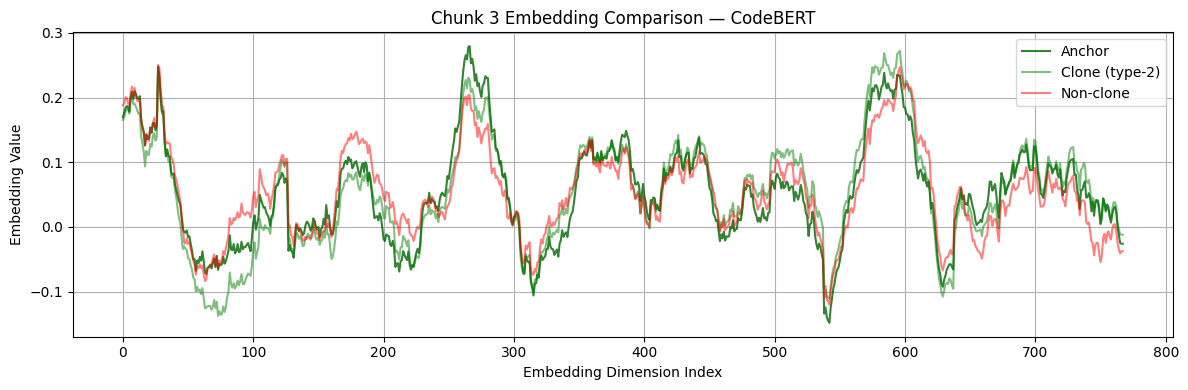

4, CUM_L2(anchor, clone)=0.3751, CUM_L2(anchor, non-clone)=1.0715
// ANCHOR:
// public void markDone(int index) { tasks.set(index, tasks.get(index) + " ✅"); }
// CLONE 1:
// public void completeItem(int idx) { taskItems.set(idx, taskItems.get(idx) + " ✅"); } // mark done
// NON-CLONE 1:
// return false;


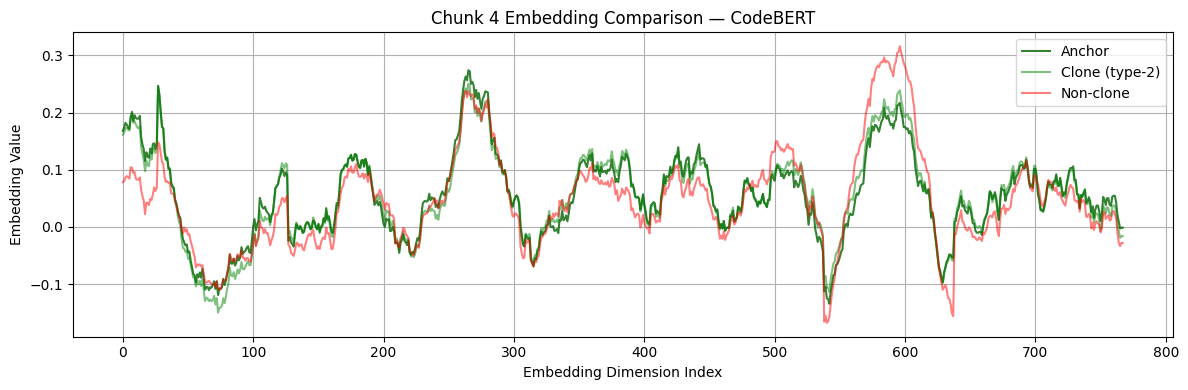

5, CUM_L2(anchor, clone)=0.2115, CUM_L2(anchor, non-clone)=1.0230
// ANCHOR:
// ToDoList list = new ToDoList();
//         list.addTask("Write code");
//         list.viewTasks();
// CLONE 1:
// TaskManager tm = new TaskManager();
//         tm.addItem("Write code");
//         tm.showItems();
// NON-CLONE 1:
// for(int r=0;r<3;r++)


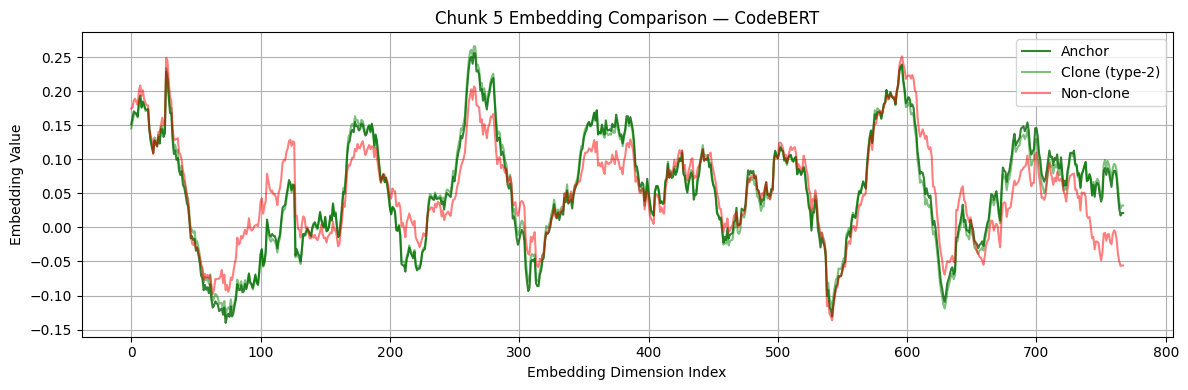


Embedding model: GraphCodeBERT
0, CUM_L2(anchor, clone)=0.4618, CUM_L2(anchor, non-clone)=1.5609
// ANCHOR:
// public void addTask(String task) { tasks.add(task); }
// CLONE 1:
// public void addItem(String item) { taskItems.add(item); } // add task
// NON-CLONE 1:
// if(grid[r][c] == '-') {


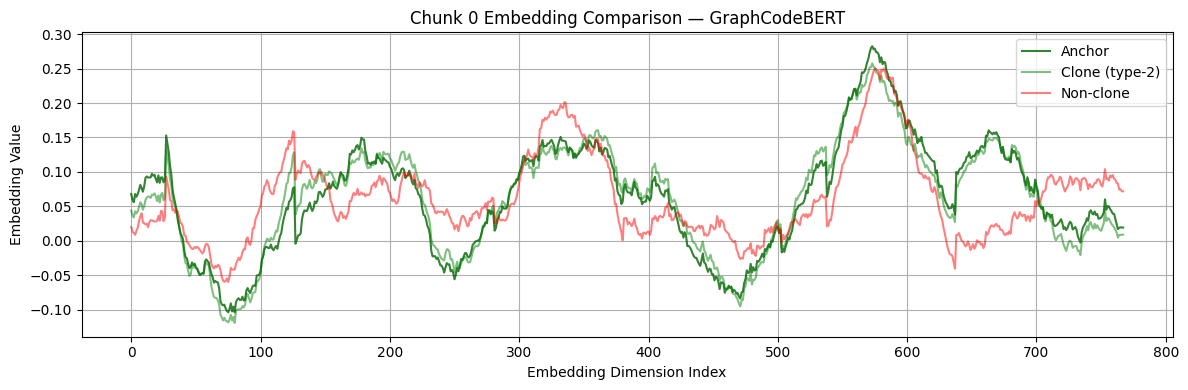

1, CUM_L2(anchor, clone)=0.5114, CUM_L2(anchor, non-clone)=1.2780
// ANCHOR:
// public void removeTask(int index) { tasks.remove(index); }
// CLONE 1:
// public void deleteItem(int idx) { taskItems.remove(idx); } // remove task
// NON-CLONE 1:
// return false;


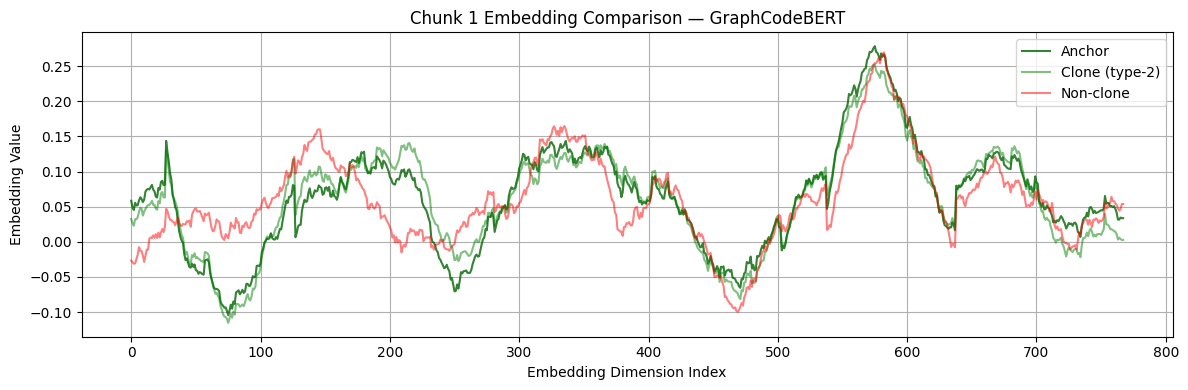

2, CUM_L2(anchor, clone)=0.4693, CUM_L2(anchor, non-clone)=1.0317
// ANCHOR:
// public void updateTask(int index, String task) { tasks.set(index, task); }
// CLONE 1:
// public void modifyItem(int idx, String item) { taskItems.set(idx, item); } // update task
// NON-CLONE 1:
// for(char[] row : grid) {


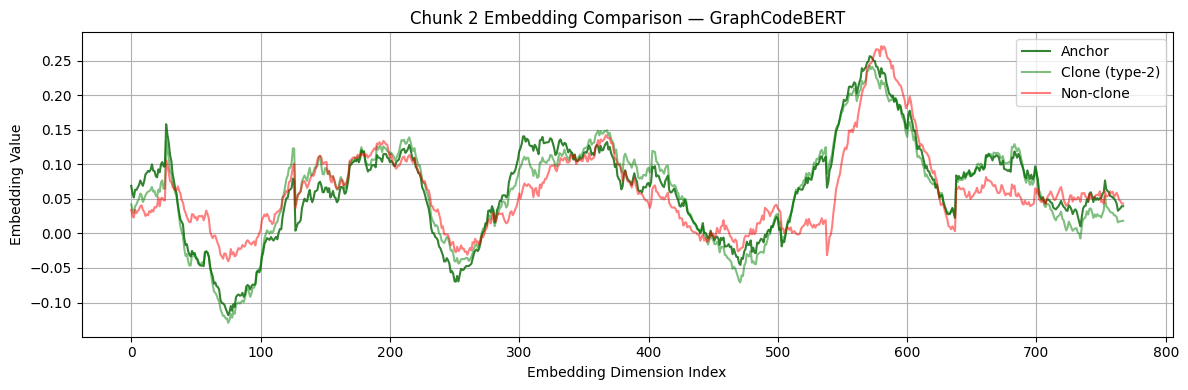

3, CUM_L2(anchor, clone)=0.3889, CUM_L2(anchor, non-clone)=1.1055
// ANCHOR:
// public void viewTasks() { tasks.forEach(System.out::println); }
// CLONE 1:
// public void showItems() { taskItems.forEach(System.out::println); } // display tasks
// NON-CLONE 1:
// for(int i=0;i<3;i++)


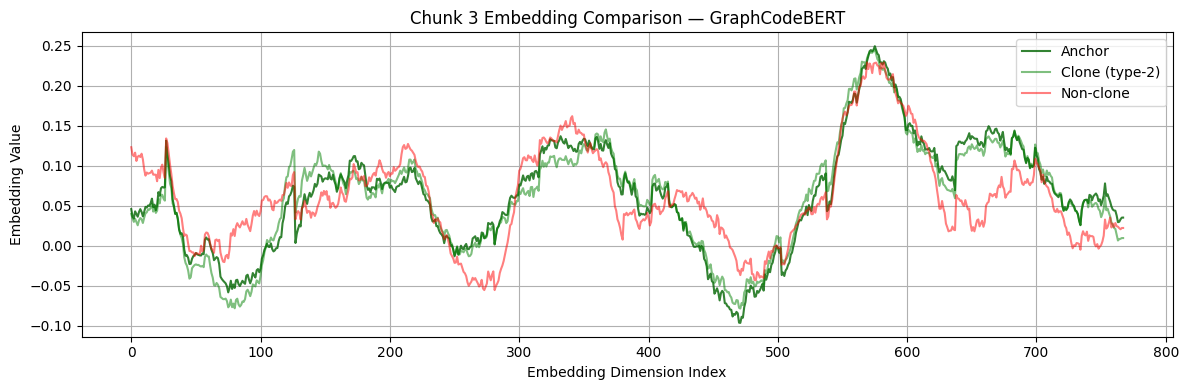

4, CUM_L2(anchor, clone)=0.3910, CUM_L2(anchor, non-clone)=1.3867
// ANCHOR:
// public void markDone(int index) { tasks.set(index, tasks.get(index) + " ✅"); }
// CLONE 1:
// public void completeItem(int idx) { taskItems.set(idx, taskItems.get(idx) + " ✅"); } // mark done
// NON-CLONE 1:
// return false;


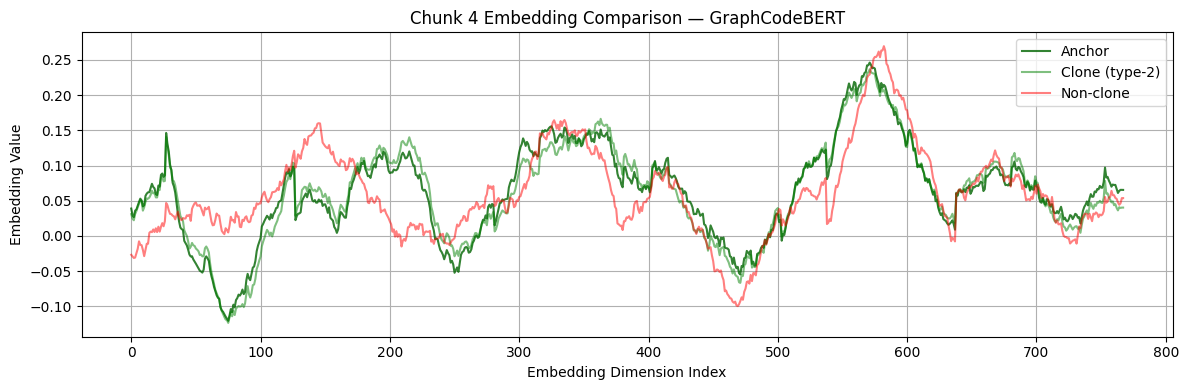

5, CUM_L2(anchor, clone)=0.4582, CUM_L2(anchor, non-clone)=1.3684
// ANCHOR:
// ToDoList list = new ToDoList();
//         list.addTask("Write code");
//         list.viewTasks();
// CLONE 1:
// TaskManager tm = new TaskManager();
//         tm.addItem("Write code");
//         tm.showItems();
// NON-CLONE 1:
// for(int r=0;r<3;r++)


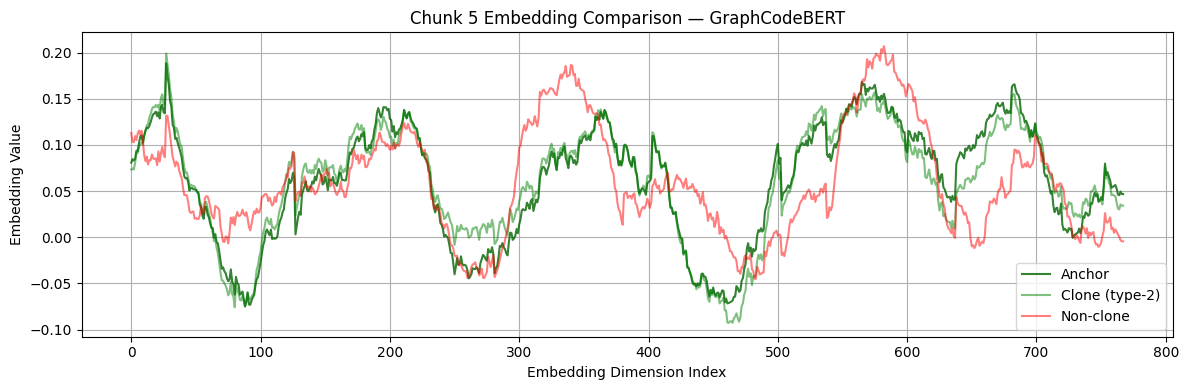

In [29]:
# Take only the first sample
sample = next(gen)
anchor, clones, non_clones = sample

# Extract code-only chunks along with method names
anchor_chunks_with_name = get_ready_to_embed_chunks(anchor)
first_clone_chunks_with_name = get_ready_to_embed_chunks(clones[0])
first_nc_chunks_with_name = get_ready_to_embed_chunks(non_clones[0])

# Helper to extract code and names separately
def extract_code_and_names(chunks_with_name):
    codes = []
    names = []
    for method_name, code, _ in chunks_with_name:  # ignore AST
        code = code.strip()
        if code:  # skip empty
            codes.append(code)
            names.append(method_name)
    return codes, names

anchor_codes, anchor_names = extract_code_and_names(anchor_chunks_with_name)
clone_codes, clone_names = extract_code_and_names(first_clone_chunks_with_name)
nc_codes, nc_names = extract_code_and_names(first_nc_chunks_with_name)

# Only consider chunks that exist in all three
num_chunks = min(len(anchor_codes), len(clone_codes), len(nc_codes))

# --- Embedding and plotting ---
for model_name, pipe in models.items():
    print(f"\nEmbedding model: {model_name}")

    anchor_emb = embed_chunks(anchor_codes[:num_chunks], pipe)
    anchor_emb = smooth_embeddings(anchor_emb) 

    clone_emb = embed_chunks(clone_codes[:num_chunks], pipe)
    clone_emb = smooth_embeddings(clone_emb)

    nc_emb = embed_chunks(nc_codes[:num_chunks], pipe)
    nc_emb = smooth_embeddings(nc_emb)

    # Plot each chunk with method name + code as comment
    for idx in range(num_chunks):
        plt.figure(figsize=(12, 4))

        plt.plot(anchor_emb[idx], color='darkgreen', alpha=0.8, label="Anchor")
        plt.plot(clone_emb[idx], color='green', alpha=0.5, label=str("Clone (" + str(clonetype) + ")"))
        plt.plot(nc_emb[idx], color='red', alpha=0.5, label="Non-clone")

        method_name = anchor_names[idx]
        plt.title(f"Chunk {idx} Embedding Comparison — {model_name}")
        plt.xlabel("Embedding Dimension Index")
        plt.ylabel("Embedding Value")
        plt.legend()
        plt.grid(True)

        # --- CUMULATIVE L2 distance (per dimension) ---
        diff_anchor_clone = anchor_emb[idx] - clone_emb[idx]
        diff_anchor_nc = anchor_emb[idx] - nc_emb[idx]

        cum_l2_anchor_clone = np.sqrt(np.cumsum(diff_anchor_clone ** 2))
        cum_l2_anchor_nc = np.sqrt(np.cumsum(diff_anchor_nc ** 2))

        final_cum_l2_ac = cum_l2_anchor_clone[-1]
        final_cum_l2_anc = cum_l2_anchor_nc[-1]


        # Prepare the combined code comment

        code_comment = "\n".join(
            ["// ANCHOR:"] +
            [f"// {line}" for line in anchor_codes[idx].splitlines()] +
            ["// CLONE 1:"] +
            [f"// {line}" for line in clone_codes[idx].splitlines()] +
            ["// NON-CLONE 1:"] +
            [f"// {line}" for line in nc_codes[idx].splitlines()]
        )
        print(
            f"{idx}, "
            f"CUM_L2(anchor, clone)={final_cum_l2_ac:.4f}, "
            f"CUM_L2(anchor, non-clone)={final_cum_l2_anc:.4f}\n"
            f"{code_comment}"
        )


        plt.tight_layout()
        plt.show()
